## **OJECTIVE : Training classification model to find the model which would optimally classify legitimate and malicious domains.**

Dataset consist of 450k samples of legitimate and malicious domain urls and here I tend to explore the dataset and then train a classifier model which would optimally predict phishing and legitimate urls.

**NOTE** : As the dataset is imbalanced i will use SMOTE to oversample dataset.

In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# **Exploratory Data Analysis**

We have 21 features out of which 18 features were extracted from dataset in the previous notebook, the 'results' feature is the ground truth while the remaining 2 features ('url' , 'label') are only there for reference and can will be removed during training of the model.

In [4]:
# loading out dataset from previous notebook
from google.colab import drive
drive.mount('/content/drive')
urldata = pd.read_csv("/content/Url_Processed.csv")

# droping "Unnamed: 0" as its unncessary feature
urldata.drop("Unnamed: 0",axis=1,inplace=True)

urldata.head(10)

Mounted at /content/drive


,url,label,result,url_length,hostname_length,path_length,fd_length,count-,count@,count?,...,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,https://www.google.com,benign,0,22,14,0,0,0,0,0,...,2,0,1,1,1,0,17,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,0,0,0,...,2,0,1,1,1,0,18,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,0,0,0,...,2,0,1,1,1,0,19,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,0,0,0,...,2,0,1,1,1,0,16,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,0,0,0,...,2,0,1,1,1,0,20,0,1,1
5,https://www.reddit.com,benign,0,22,14,0,0,0,0,0,...,2,0,1,1,1,0,17,0,1,-1
6,https://www.yahoo.com,benign,0,21,13,0,0,0,0,0,...,2,0,1,1,1,0,16,0,1,1
7,https://www.google.co.in,benign,0,24,16,0,0,0,0,0,...,3,0,1,1,1,0,18,0,1,1
8,https://www.qq.com,benign,0,18,10,0,0,0,0,0,...,2,0,1,1,1,0,13,0,1,1
9,https://www.amazon.com,benign,0,22,14,0,0,0,0,0,...,2,0,1,1,1,0,17,0,1,1


In [5]:
urldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   url              450176 non-null  object
 1   label            450176 non-null  object
 2   result           450176 non-null  int64 
 3   url_length       450176 non-null  int64 
 4   hostname_length  450176 non-null  int64 
 5   path_length      450176 non-null  int64 
 6   fd_length        450176 non-null  int64 
 7   count-           450176 non-null  int64 
 8   count@           450176 non-null  int64 
 9   count?           450176 non-null  int64 
 10  count%           450176 non-null  int64 
 11  count.           450176 non-null  int64 
 12  count=           450176 non-null  int64 
 13  count-http       450176 non-null  int64 
 14  count-https      450176 non-null  int64 
 15  count-www        450176 non-null  int64 
 16  count-digits     450176 non-null  int64 
 17  count-lett

benign       345738
malicious    104438
Name: label, dtype: int64


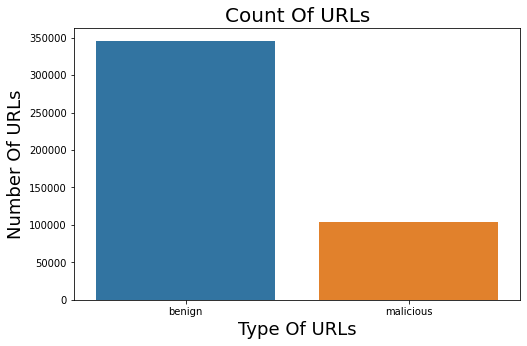

In [7]:
# Lets find how many malicious and non-malicious samples we have
i = urldata["label"].value_counts()
print(i)

plt.figure(figsize=(8,5))
sns.countplot(x='label',data=urldata)
plt.title("Count Of URLs",fontsize=20)
plt.xlabel("Type Of URLs",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)
plt.show()

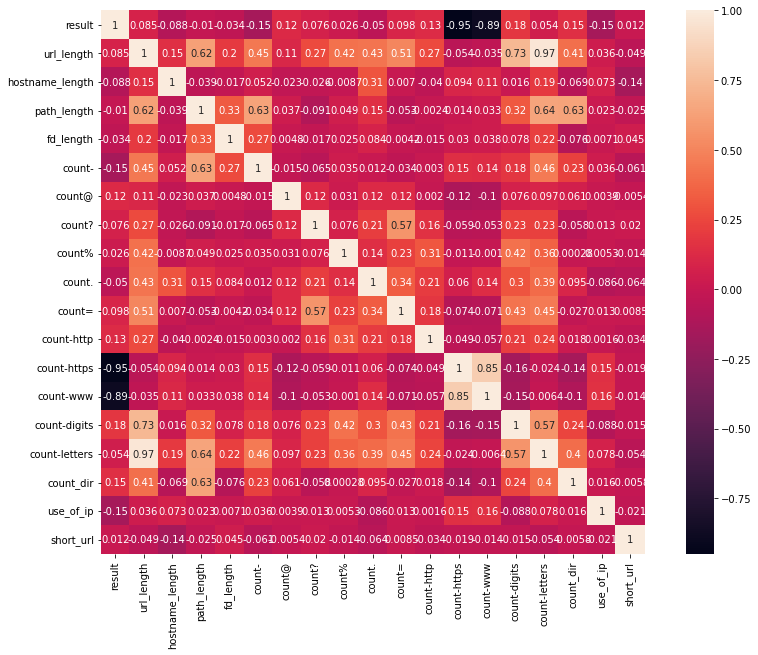

In [8]:

#Correlation Heatmap
corrmat = urldata.corr()
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corrmat, square=True, annot = True, annot_kws={'size':10})

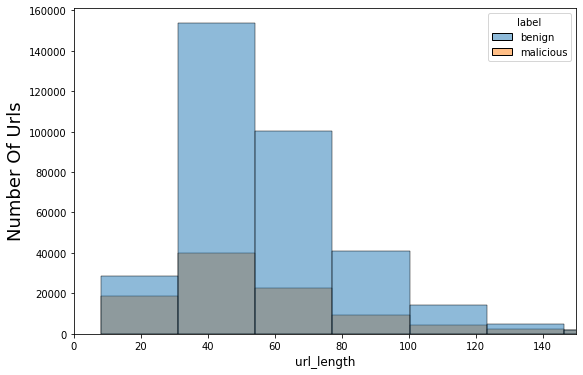

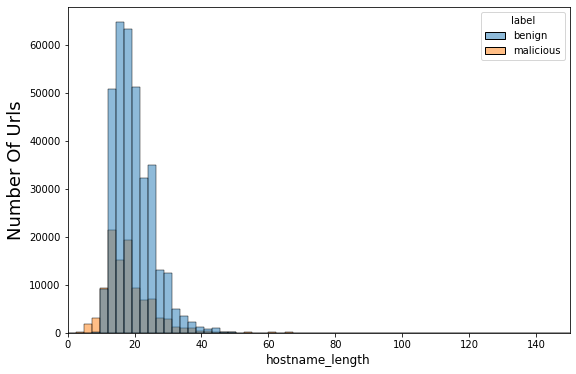

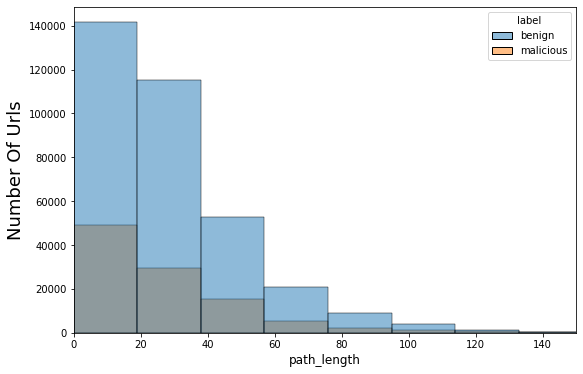

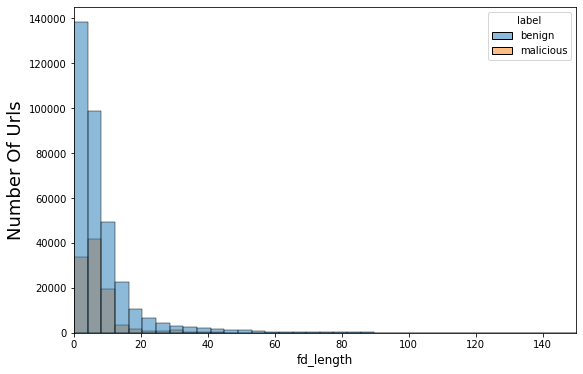

In [11]:
# setting plot sizes
from matplotlib import rcParams
rcParams['figure.figsize'] = 9,6

# plotting distrubutions
features = list(urldata.columns) # list of feature names
features.remove("url")
features.remove("result")

hist_features = ["url_length","hostname_length","path_length","fd_length"]

for i in hist_features:
   sns.histplot(data=urldata,x=i,bins=100,hue='label')
   plt.xlabel(i,fontsize=12)
   plt.ylabel("Number Of Urls",fontsize=18)
   plt.xlim(0,150)
   plt.show()

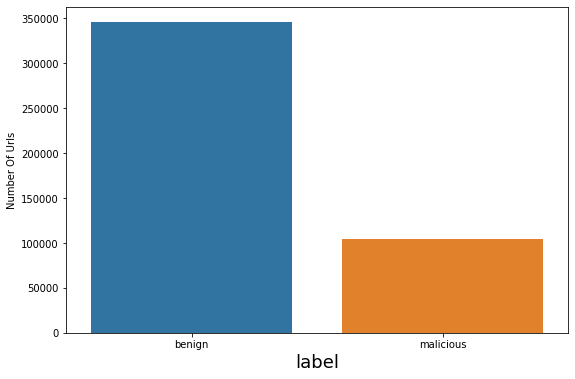

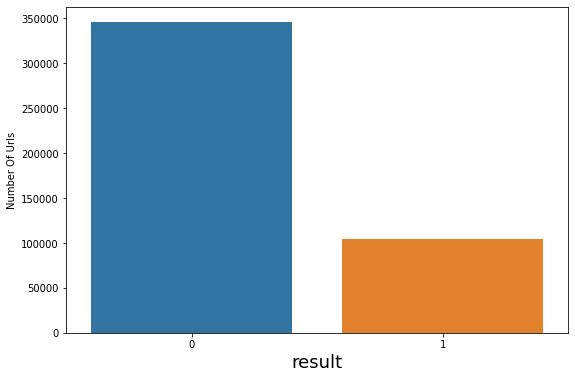

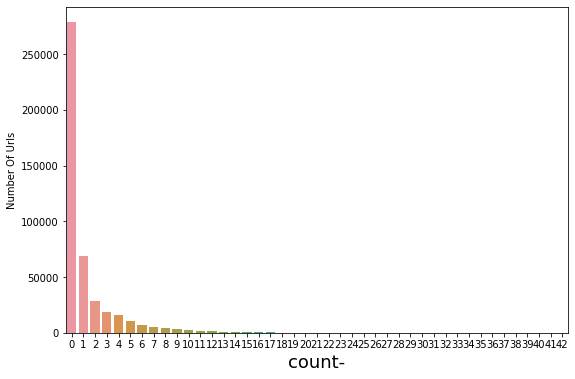

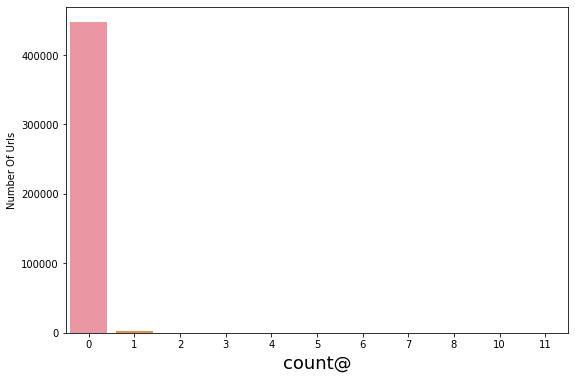

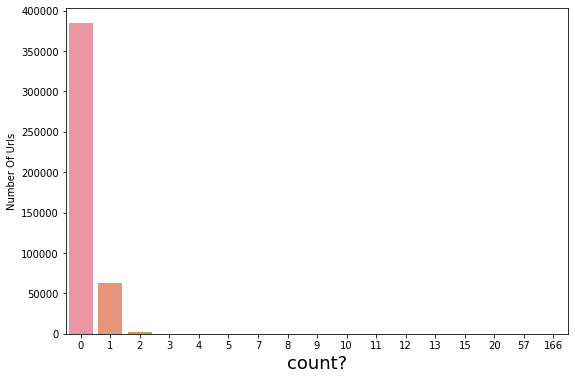

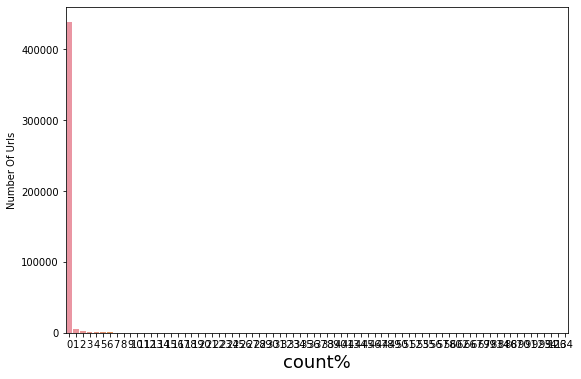

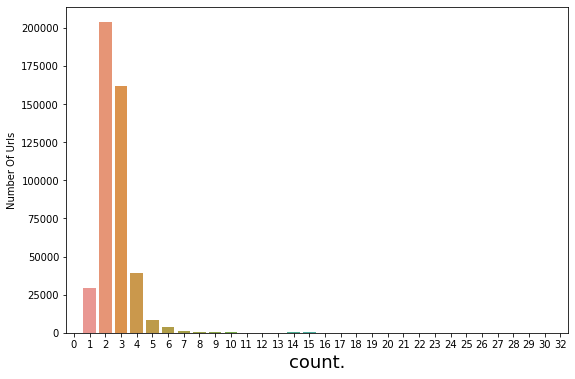

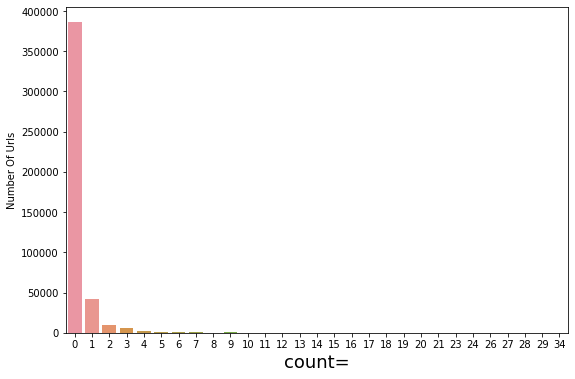

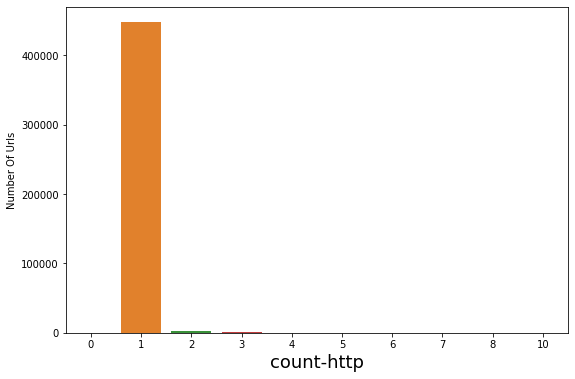

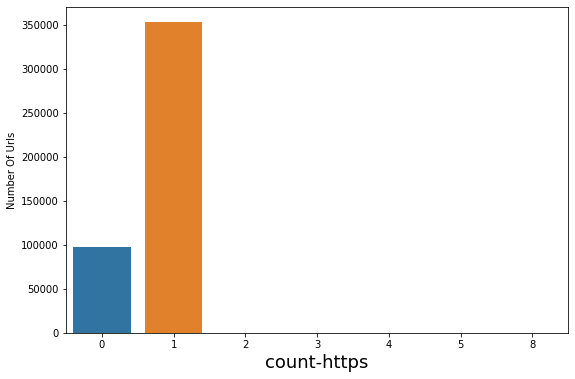

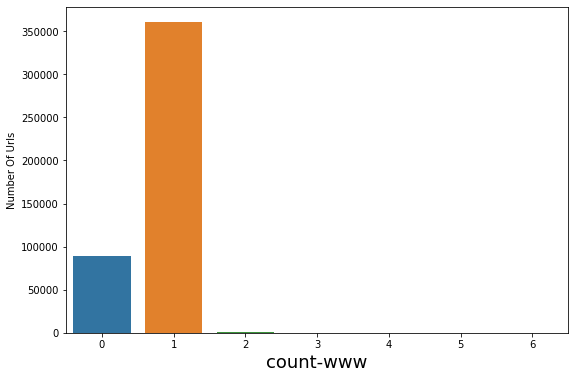

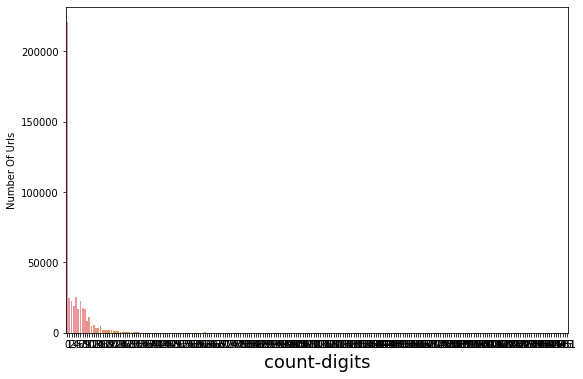

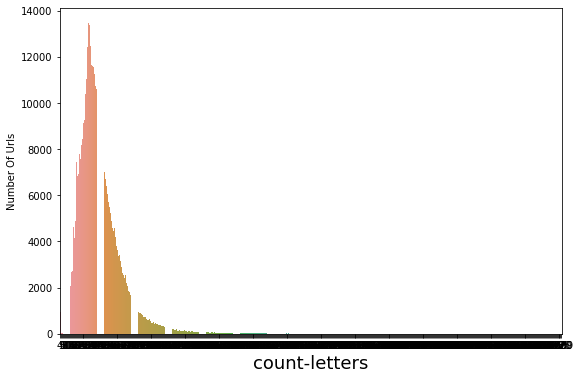

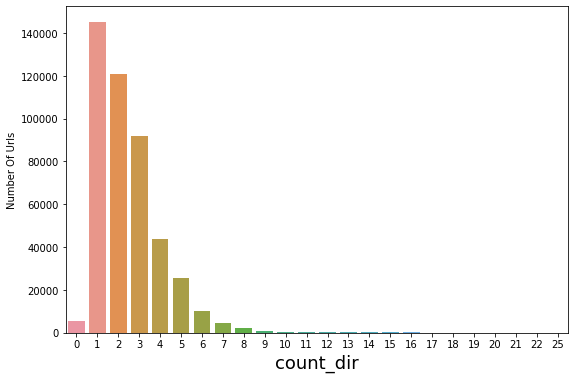

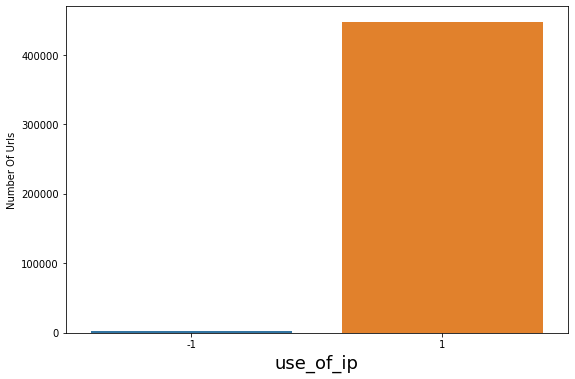

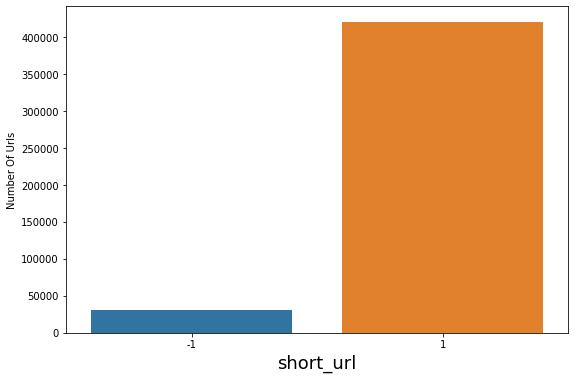

In [12]:
# plotting distrubutions

features = list(urldata.columns) # list of feature names
features.remove("url")

rcParams['figure.figsize'] = 9,6

for i in features:
   
   if i in hist_features:
     continue
   
   sns.countplot(x=i,data=urldata)
   plt.xlabel(i,fontsize=10)
   plt.ylabel("Number Of Urls",fontsize=10)
   plt.show()
  

# **Model Training**

Before training our models we'll split the data into train and test dataset. We'll train multiple models and choose the one which gives us the best validation-accuracy. This problem falls under "Binary classification" and some of the models we'll train are :
- Decision Tree
- Random Forest
- Multilayer Perceptron (deep learning)

### **Data Splitting**

We'll follow a 80:20 ratio for data splitting,where we use 80% of data for training and 20% for testing.

In [13]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,count-,count@,count?,...,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,https://www.google.com,benign,0,22,14,0,0,0,0,0,...,2,0,1,1,1,0,17,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,0,0,0,...,2,0,1,1,1,0,18,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,0,0,0,...,2,0,1,1,1,0,19,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,0,0,0,...,2,0,1,1,1,0,16,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,0,0,0,...,2,0,1,1,1,0,20,0,1,1


In [14]:
# remove uneccessary columns
urldata.drop(["url","label"],axis=1,inplace=True)

urldata.head()

,result,url_length,hostname_length,path_length,fd_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,0,22,14,0,0,0,0,0,0,2,0,1,1,1,0,17,0,1,1
1,0,23,15,0,0,0,0,0,0,2,0,1,1,1,0,18,0,1,1
2,0,24,16,0,0,0,0,0,0,2,0,1,1,1,0,19,0,1,1
3,0,21,13,0,0,0,0,0,0,2,0,1,1,1,0,16,0,1,1
4,0,25,17,0,0,0,0,0,0,2,0,1,1,1,0,20,0,1,1


In [15]:
# NOTE : We'll use only lexical features for this notebook i,e not taking 'url_length' and 'short_url'

#Independent Variables
x = urldata[['hostname_length',
       'path_length', 'fd_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']]

#Dependent Variable
y = urldata['result']

In [16]:
# printing x
x.head()

,hostname_length,path_length,fd_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip
0,14,0,0,0,0,0,0,2,0,1,1,1,0,17,0,1
1,15,0,0,0,0,0,0,2,0,1,1,1,0,18,0,1
2,16,0,0,0,0,0,0,2,0,1,1,1,0,19,0,1
3,13,0,0,0,0,0,0,2,0,1,1,1,0,16,0,1
4,17,0,0,0,0,0,0,2,0,1,1,1,0,20,0,1


In [17]:
# printing y
y.head()

0    0
1    0
2    0
3    0
4    0
Name: result, dtype: int64

#### **Oversampling Imbalanced Dataset**

During EDA we found that our dataset is Imbalanced,so we'll now use SMOTE method to oversample the dataset.

In [ ]:
#Oversampling using SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)

x_sample, y_sample = SMOTE().fit_resample(x, y.values.ravel())

x_sample = pd.DataFrame(x_sample)
y_sample = pd.DataFrame(y_sample)

In [23]:
# checking the sizes of the sample data
print("Size of x-sample :", x_sample.shape)
print("Size of y-sample :", y_sample.shape)

Size of x-sample : (691476, 16)
Size of y-sample : (691476, 1)


In [24]:
# DATA SPLITTING 

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size = 0.2)
print("Shape of x_train: ", x_train.shape)
print("Shape of x_valid: ", x_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_valid: ", y_test.shape)

Shape of x_train:  (553180, 16)
Shape of x_valid:  (138296, 16)
Shape of y_train:  (553180, 1)
Shape of y_valid:  (138296, 1)


## **1] Decision Tree**

A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes).

In [25]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=7)

# start training the model
model.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=7)

#### **Model Performance Evaluation**

In [26]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# finding y_pred for train and test dataset
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# finding accuracy on train dataset
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,y_pred_test)

print("Accuracy on Training dataset : ",round(train_acc,3))
print("Accuracy on Testing dataset : ",round(test_acc,3))

Accuracy on Training dataset :  0.998
Accuracy on Testing dataset :  0.997


In [27]:
# calculating other classification metrics
print(classification_report(y_pred_test,y_test,target_names=["legitimate","malicious"]))

              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     69197
   malicious       1.00      1.00      1.00     69099

    accuracy                           1.00    138296
   macro avg       1.00      1.00      1.00    138296
weighted avg       1.00      1.00      1.00    138296



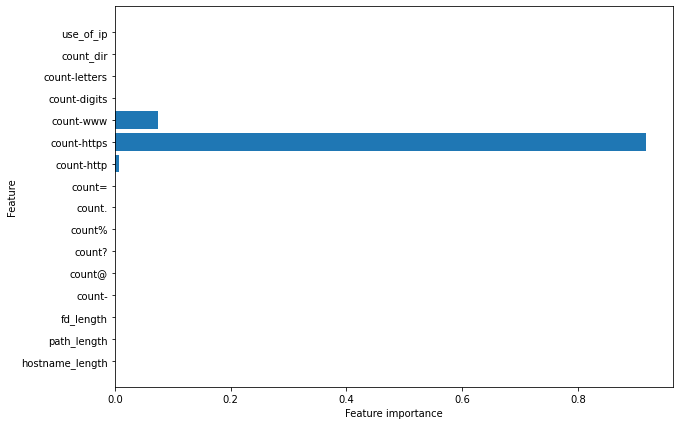

In [30]:

feature_names = ['hostname_length',
       'path_length', 'fd_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']

#checking the feature improtance in the model
plt.figure(figsize=(10,7))
n_features = x_train.shape[1]
plt.barh(range(n_features), model.feature_importances_, align='center')
plt.yticks(np.arange(n_features),feature_names)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

## **2] Random Forest**
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees.

In [31]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=7)

# start training the model
model.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(max_depth=7)

#### **Model Performance Evaluation**

In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# finding y_pred for train and test dataset
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# finding accuracy on train dataset
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,y_pred_test)

print("Accuracy on Training dataset : ",round(train_acc,3))
print("Accuracy on Testing dataset : ",round(test_acc,3))

Accuracy on Training dataset :  0.997
Accuracy on Testing dataset :  0.997


In [33]:
# calculating other classification metrics
print(classification_report(y_pred_test,y_test,target_names=["legitimate","malicious"]))

              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     69208
   malicious       1.00      1.00      1.00     69088

    accuracy                           1.00    138296
   macro avg       1.00      1.00      1.00    138296
weighted avg       1.00      1.00      1.00    138296



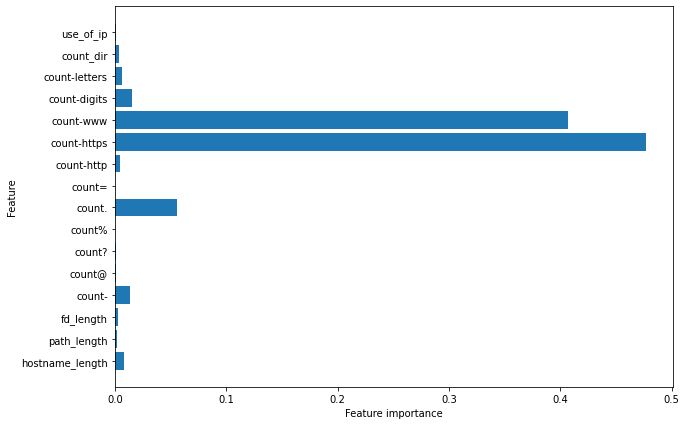

In [35]:

feature_names = ['hostname_length',
       'path_length', 'fd_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']

#checking the feature improtance in the model
plt.figure(figsize=(10,7))
n_features = x_train.shape[1]
plt.barh(range(n_features), model.feature_importances_, align='center')
plt.yticks(np.arange(n_features),feature_names)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

## **3] Multilayer Perceptron (Deep Learning)**
A multilayer perceptron (MLP) is a feedforward artificial neural network that generates a set of outputs from a set of inputs. An MLP is characterized by several layers of input nodes connected as a directed graph between the input and output layers. MLP uses backpropogation for training the network.

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization ,Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [37]:
# print input shape
x_train.shape

(553180, 16)

In [38]:
# model building
model = Sequential()
model.add(Dense(32, activation = 'relu', input_shape = (16, )))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [39]:
# compiling model
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer= opt ,loss='binary_crossentropy',metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
# custom callback to stop the training when certain metric value is reached

# stop training when validation loss reach 0.1
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.1):
            print("\nReached 0.1 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

In [41]:
# start training the model 
history = model.fit(x_train, y_train, epochs=10,batch_size=256, callbacks=[callback],validation_data=(x_test,y_test),verbose=1)

Epoch 1/10
2161/2161 [==============================] - 10s 4ms/step - loss: 0.4202 - acc: 0.8337 - val_loss: 0.1394 - val_acc: 0.9739
Epoch 2/10
2154/2161 [============================>.] - ETA: 0s - loss: 0.0749 - acc: 0.9832
Reached 0.1 val_loss so cancelling training!
2161/2161 [==============================] - 4s 2ms/step - loss: 0.0748 - acc: 0.9832 - val_loss: 0.0432 - val_acc: 0.9925


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


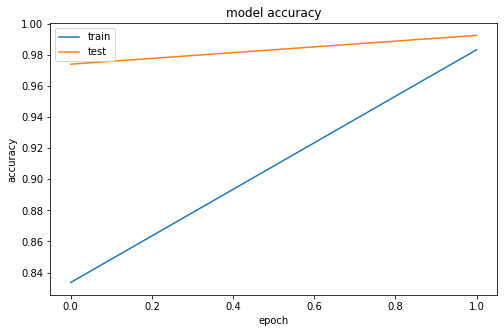

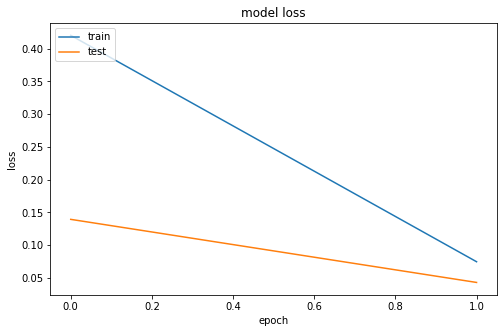

In [43]:
# DISPLAYING MODEL TRAINING HISTORY

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [44]:

# Evaluate the model on test dataset
loss, acc = model.evaluate(x_test,y_test,verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

4322/4322 [==============================] - 6s 1ms/step - loss: 0.0432 - acc: 0.9925
Test loss: 0.043157909065485
Test Accuracy: 0.9924654364585876


In [45]:
# predicting on test data.
pred_test = model.predict(x_test)
for i in range (len(pred_test)):
    if (pred_test[i] < 0.5):
        pred_test[i] = 0
    else:
        pred_test[i] = 1
pred_test = pred_test.astype(int)

def view_result(array):
    array = np.array(array)
    for i in range(len(array)):
        if array[i] == 0:
            print("Non Mallicious")
        else:
            print("Mallicious")

print("PREDICTED : ")
view_result(pred_test[:10])
print("\n")
print("ACTUAL : ")
view_result(y_test[:10])

PREDICTED : 
Non Mallicious
Non Mallicious
Mallicious
Mallicious
Non Mallicious
Non Mallicious
Non Mallicious
Non Mallicious
Non Mallicious
Non Mallicious


ACTUAL : 
Non Mallicious
Non Mallicious
Mallicious
Mallicious
Non Mallicious
Non Mallicious
Non Mallicious
Non Mallicious
Non Mallicious
Non Mallicious


### **Saving the prediction model**

In [ ]:
# Save Model Weights and Architecture Together
model.save("Malicious_URL_Prediction.h5")

### This test can be further enhanced with creating a phishing detecting webportal where the trained and saved our models can be used. 